In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
!ls /data/vnkljukin

bert_autoencoder_RMSE0.0461780910955467.model  encoded_bert_tsne.png
bert_autoencoders			       items.json
both_bert_tsne.png			       original_bert_tsne.png
checkpoints				       solution.csv
content_embeddings_bert.npy		       title_embeddings_bert.npy
encoded_bert_128.npy			       train.csv


In [ ]:
title_embeddings_bert = np.load('/data/vnkljukin/title_embeddings_bert.npy')
title_embeddings_bert = title_embeddings_bert[:-1, :]
title_embeddings_bert.shape

In [4]:
from torch.utils.data import DataLoader, Dataset

In [5]:
class BertEmbeddingDataset(Dataset):
    """Wrapper, convert title_embeddings_bert Tensor into Pytorch Dataset"""

    def __init__(self, title_embeddings_bert):
        """
        args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self.title_embeddings_bert = title_embeddings_bert

    def __getitem__(self, index):
        return self.title_embeddings_bert[index, :]

    def __len__(self):
        return self.title_embeddings_bert.size(0)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test = train_test_split(title_embeddings_bert, test_size=0.2)
X_train.shape, X_test.shape

((262440, 768), (65610, 768))

In [8]:
train_dataset = BertEmbeddingDataset(torch.as_tensor(X_train).cuda())
test_dataset = BertEmbeddingDataset(torch.as_tensor(X_test).cuda())
len(train_dataset), len(test_dataset)

(262440, 65610)

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
        )
        self.dec = nn.Sequential(
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 768)
        )
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [10]:
BATCH_SIZE = 128

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
device = torch.device("cuda")
device

device(type='cuda')

In [13]:
from tqdm.notebook import tqdm

In [46]:
!ls /data/vnkljukin/bert_autoencoders

In [31]:
def train(model, num_epoch=50):
    model.double()
    model.to(device)
    gd = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    test_scores = []
    train_scores = []

    for epoch in range(num_epoch):
        model.train()
        losses = []
        scores = []
        for i, (batch) in tqdm(enumerate(train_loader), total=len(train_loader)):
            gd.zero_grad()
            batch = batch.cuda().double()
            loss = criterion(model(batch), batch)
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        
        model.eval()
        for i, (batch) in tqdm(enumerate(test_loader), total=len(test_loader)):
            batch = batch.cuda().double()
            scores.append(criterion(model(batch), batch).item())
        reconstruction_mse = np.mean(scores)
        print("#%i, Train loss: %.7f"%(epoch+1, np.mean(losses)) + f' Test loss: {reconstruction_mse:.7f}',
              flush=True)
        train_scores.append(np.mean(losses))
        test_scores.append(reconstruction_mse)
        torch.save(model.state_dict(), 
                   f'/data/vnkljukin/bert_autoencoders/bert_autoencoder_epoch{epoch}_RMSE{np.sqrt(reconstruction_mse):.7f}.model')
    return train_scores, test_scores

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [47]:
model = AutoEncoder()
train, test = train(model, 30)


#1, Train loss: 0.0110681 Test loss: 0.0066347



#2, Train loss: 0.0064694 Test loss: 0.0052768



#3, Train loss: 0.0053476 Test loss: 0.0044786



#4, Train loss: 0.0048123 Test loss: 0.0043615



#5, Train loss: 0.0043555 Test loss: 0.0037327



#6, Train loss: 0.0039753 Test loss: 0.0033862



#7, Train loss: 0.0036393 Test loss: 0.0031440



#8, Train loss: 0.0034341 Test loss: 0.0132963



#9, Train loss: 0.0036587 Test loss: 0.0030201



#10, Train loss: 0.0033013 Test loss: 0.0028150



#11, Train loss: 0.0032033 Test loss: 0.0029237



#12, Train loss: 0.0030506 Test loss: 0.0025818



#13, Train loss: 0.0030254 Test loss: 0.0027302



#14, Train loss: 0.0029545 Test loss: 0.0024732



#15, Train loss: 0.0028553 Test loss: 0.0024120



#16, Train loss: 0.0030203 Test loss: 0.0024657



#17, Train loss: 0.0027703 Test loss: 0.0024124



#18, Train loss: 0.0027309 Test loss: 0.0034698



#19, Train loss: 0.0028092 Test loss: 0.0022232



#20, Train loss: 0.0026416 Test loss: 0.0022804



#21, Train loss: 0.0026307 Test loss: 0.0024716



#22, Train loss: 0.0025745 Test loss: 0.0026931



#23, Train loss: 0.0025802 Test loss: 0.0021996



#24, Train loss: 0.0024851 Test loss: 0.0023802



#25, Train loss: 0.0025841 Test loss: 0.0021415



#26, Train loss: 0.0025755 Test loss: 0.0021859



#27, Train loss: 0.0024731 Test loss: 0.0021510



#28, Train loss: 0.0024298 Test loss: 0.0027760



#29, Train loss: 0.0024269 Test loss: 0.0023101



#30, Train loss: 0.0023925 Test loss: 0.0021211


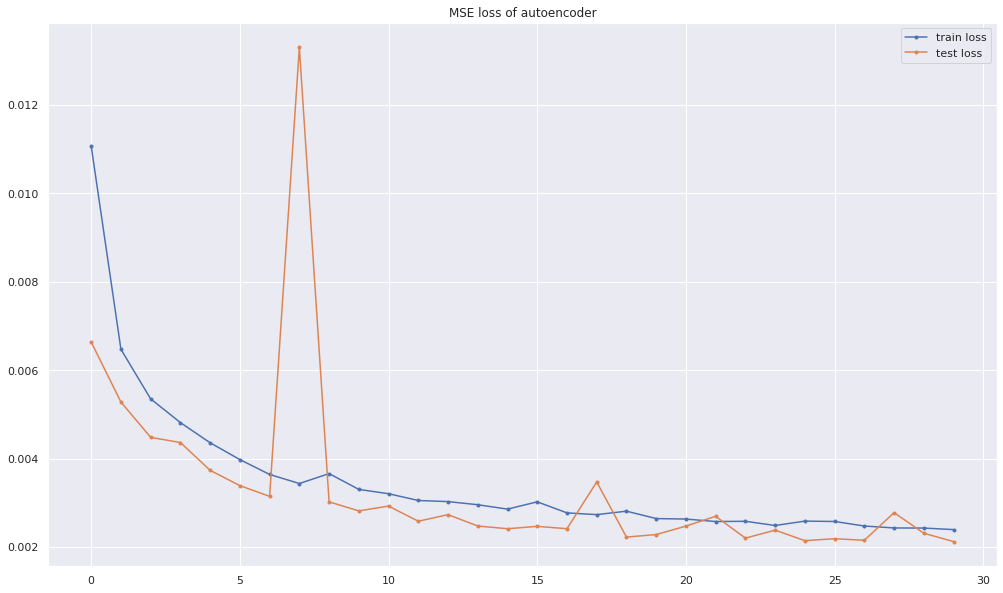

In [48]:
plt.figure(figsize=(17, 10))
plt.title('MSE loss of autoencoder')
plt.plot(train, marker='.', label='train loss')
plt.plot(test, marker='.', label='test loss')
# plt.savefig('/data/vnkljukin/AEC_loss.png')
plt.legend()
plt.show()

In [65]:
!ls /data/vnkljukin/

bert_autoencoder_RMSE0.0461780910955467.model
bert_autoencoder_RMSE0.04644227364172243.model
bert_autoencoder_RMSE0.04646437232610478.model
bert_autoencoder_RMSE0.04652739415474878.model
bert_autoencoder_RMSE0.046600907015108654.model
bert_autoencoder_RMSE0.0466095576906374.model
bert_autoencoder_RMSE0.046672258143340375.model
bert_autoencoder_RMSE0.04681799667130117.model
bert_autoencoder_RMSE0.047332976450783715.model
bert_autoencoder_RMSE0.04763242485227055.model
bert_autoencoder_RMSE0.04768955214795069.model
bert_autoencoder_RMSE0.05061712402414585.model
bert_autoencoder_RMSE0.05080375583243451.model
bert_autoencoder_RMSE0.05310687872880776.model
bert_autoencoder_RMSE0.053170790211484.model
bert_autoencoder_RMSE0.0532721452044657.model
bert_autoencoder_RMSE0.053379400510336725.model
bert_autoencoder_RMSE0.053487148992905874.model
bert_autoencoder_RMSE0.05357538315269993.model
bert_autoencoder_RMSE0.05372365642995216.model
bert_autoencoder_RMSE0.05386844528819031.model
bert_autoenco

In [55]:
import os
for file in os.listdir("/data/vnkljukin/bert_autoencoders"):
    if file not in ('bert_autoencoder_epoch24_RMSE0.0462760.model',):
        os.remove('/data/vnkljukin/bert_autoencoders/' + file)

In [56]:
!ls /data/vnkljukin

AEC_loss.png				       encoded_bert_tsne.png
bert_autoencoder_RMSE0.0461780910955467.model  items.json
bert_autoencoders			       original_bert_tsne.png
both_bert_tsne.png			       solution.csv
checkpoints				       title_embeddings_bert.npy
content_embeddings_bert.npy		       train.csv
encoded_bert_128.npy


In [57]:
title_embeddings_bert.std(axis=0).mean()

0.1866939

In [34]:
total_dataset = BertEmbeddingDataset(torch.as_tensor(title_embeddings_bert).cuda())

In [50]:
state_dict = torch.load('/data/vnkljukin/bert_autoencoders/bert_autoencoder_epoch24_RMSE0.0462760.model',
                        map_location=lambda storage, loc: storage.cuda(
                            device=0
                        ))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [51]:
total_loader = DataLoader(total_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [52]:
losses = []
model.eval()
criterion = nn.MSELoss(reduce=False)

for i, (batch) in tqdm(enumerate(total_loader), total=len(total_loader)):
    batch = batch.cuda().double()
    prediction = model(batch)
    loss = criterion(batch, prediction)
    losses.append(loss.cpu().detach().numpy())
losses = np.concatenate(losses)
losses

array([[1.85075658e-03, 2.88287317e-08, 2.72409768e-03, ...,
        1.36784077e-05, 3.34722292e-04, 1.76394092e-06],
       [7.76975899e-03, 4.63288814e-03, 2.82522717e-03, ...,
        3.54660001e-04, 1.10437582e-03, 5.59572866e-04],
       [1.08007539e-03, 4.16820440e-05, 6.63431458e-03, ...,
        6.23729011e-08, 9.97166144e-04, 4.02093148e-04],
       ...,
       [1.24898183e-03, 4.28105502e-04, 8.15841921e-04, ...,
        1.24253214e-04, 7.41237604e-05, 1.54188808e-05],
       [8.70172454e-06, 5.40427108e-06, 8.01787269e-03, ...,
        4.53151473e-04, 9.37300816e-04, 2.14969203e-04],
       [6.17089713e-04, 6.90518723e-06, 6.94795882e-03, ...,
        5.59674117e-03, 2.49775958e-05, 2.52555092e-03]])

In [53]:
losses.mean(axis=1).max()

0.03596796861794636

In [58]:
encoded_bert = []
for i, (batch) in tqdm(enumerate(total_loader), total=len(total_loader)):
    batch = batch.cuda().double()
    encoded_bert.append(model.enc(batch).cpu().detach().numpy())
encoded_bert = np.concatenate(encoded_bert, axis=0)
encoded_bert.shape

(328050, 128)

In [59]:
encoded_bert

array([[-4.55652409,  2.31092205,  9.28145043, ...,  1.84544084,
        -8.25578246, -1.32788951],
       [-2.4370762 ,  9.4127443 ,  7.18133172, ..., -0.41308998,
        -4.51669303,  0.18799507],
       [ 0.33106583,  5.97218312,  7.52641404, ...,  0.01860898,
        -6.22862448,  2.20282348],
       ...,
       [-4.07545943,  5.05635532,  7.39500205, ...,  2.90657753,
        -3.84764553, -2.32301005],
       [-4.5856261 ,  6.55726833,  6.35594431, ...,  2.81111484,
        -6.62036917,  0.60611562],
       [ 0.54631353,  5.68782077,  3.69073155, ...,  1.05751359,
        -6.22417878, -1.39551926]])

In [73]:
np.save('/data/vnkljukin/encoded_bert_128', encoded_bert)

# draw encoded and original

In [61]:
import tsne_utils as utils
from openTSNE import TSNE

In [65]:
tsne1 = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=20,
    random_state=42,
)

In [66]:
original_train = tsne1.fit(title_embeddings_bert)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

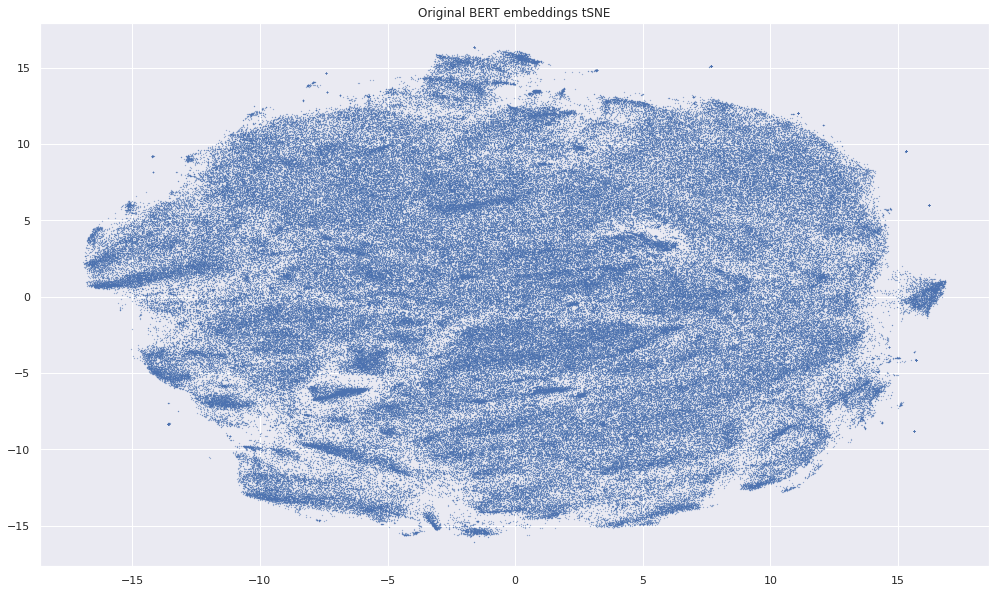

In [68]:
plt.figure(figsize=(17, 10))
plt.scatter(original_train[:,0], original_train[:,1], s=0.05)
plt.title('Original BERT embeddings tSNE')
plt.savefig('/data/vnkljukin/original_bert_tsne.png')
plt.show()

In [62]:
tsne2 = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=20,
    random_state=42,
)

In [63]:
encoded_train = tsne2.fit(encoded_bert)

/home/vnkljukin/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


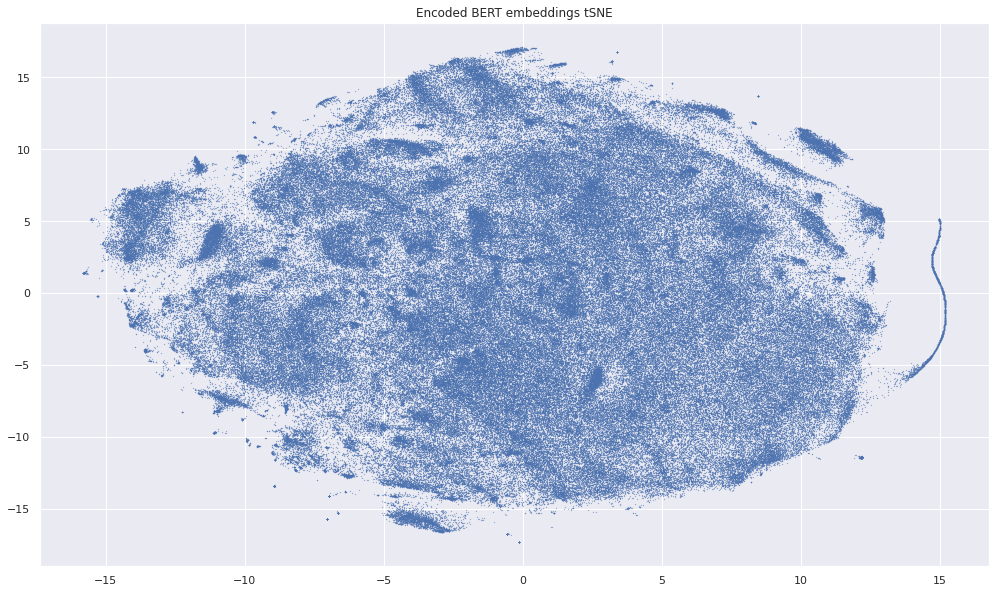

In [69]:
plt.figure(figsize=(17, 10))
plt.scatter(encoded_train[:,0], encoded_train[:,1], s=0.05)
plt.title('Encoded BERT embeddings tSNE')
plt.savefig('/data/vnkljukin/encoded_bert_tsne.png')
plt.show()

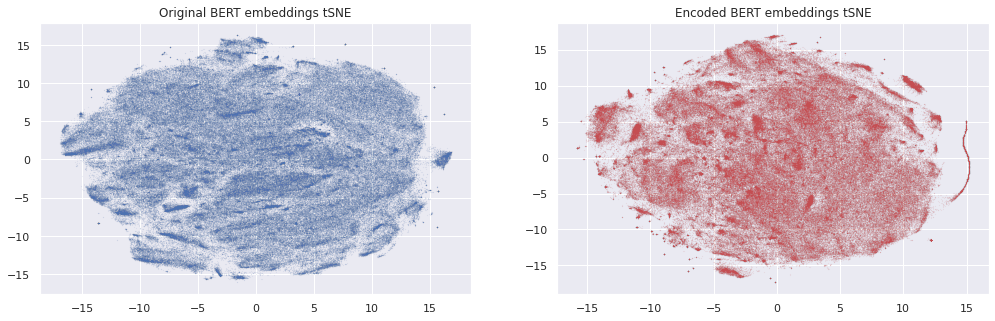

In [72]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.scatter(original_train[:,0], original_train[:,1], s=0.001)
plt.title('Original BERT embeddings tSNE')

plt.subplot(1, 2, 2)
plt.scatter(encoded_train[:,0], encoded_train[:,1], s=0.001, c='r')
plt.title('Encoded BERT embeddings tSNE')
plt.savefig('/data/vnkljukin/both_bert_tsne.png')
plt.show()